In [33]:
%run classes.ipynb
# Training cell
import numpy as np
from sklearn.model_selection import train_test_split

emptyRatioA = 47
emptyRatioB = 30
emptyRatioC = 24
objectwidth = 83
objectheight = 122

odtype = 'moran'
neighbourhoodDistance = 5
porositythreshold = 0.5
neighbourhoodZ = 1
windowSize = 75
windowAdvance = 25
noOfBins = 20
n_neighbors = 3
test_size = 0.4
hsegments = [0,26,50,74,98,122]
mask = np.zeros((objectwidth, objectheight))
bend = 225

X_train = readRawTreeImages()
labels = getLabels(porositythreshold)
Y_train = np.copy(labels)

# Todo: Uncomment this line

mask = makeMask(X_train, emptyRatioA)

bgr = backgroundRemover(mask)
ab = blockAccumulator(windowSize, windowAdvance)
oc1 = outlierCalculator(odtype, neighbourhoodDistance, neighbourhoodZ)
# a1 = accumulator(windowSize, windowOffset)

# Hur modellerar vi det här? Objekt med olika höjd blir kaos, eller? Skulle kunna skicka tomma bilder när de är slut. 

allTrainingHists = []

def makesegments(image, hsegments):
    segments = []
    for obimg in image:
        for i in range(len(hsegments)-1):
            segments.append(obimg[hsegments[i]:hsegments[i+1],:])
    return segments

trainObjects1 = np.moveaxis(X_train, 1, 0)

allOcvals = []
allPresValues = []
i = 0
for image in trainObjects1:
    # Ta bilden, omvandla till en array av bilder (en bild per obj)
    # Vilken struktur behöver preprocess? Lista med numpy array
    # image är 26x122x83
    # segments ska vara (26*5)x122x83
    noback = bgr.removeBackground(image)
    segments = makesegments(noback, hsegments)
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    # plt.hist(trainoutliers[0][1].flatten(), bins=bincount, range=(minval, maxval))
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)
    i+=1
    # if(i == 0 or i == 1 or i == 2):
    #     plt.imshow(pres[0])
    #     plt.figure()
    #     plt.hist(pres[0].flatten())
    #     plt.yscale('log')
    #     plt.figure()
    # ocVals: List[layers][objects][matrix]

acount = len(trainObjects1)
oc1.reset()
ab.reset()

X_train2 = readRawHouseImages()
trainObjects2 = np.moveaxis(X_train2, 1, 0)
maskB = makeMaskB(X_train2, emptyRatioB)
bgrb = backgroundRemover(maskB)
for image in trainObjects2:
    noback = bgrb.removeBackground(image)
    segments = noback
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    ocvals = oc1.calculate(segmentblocks)
    allOcvals.append(ocvals)

ocmin = np.nanmin(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
ocmax = np.nanmax(np.concatenate([np.concatenate([o.flatten() for o in oo]) for oo in allOcvals]))
e1 = encoder(noOfBins, ocmin, ocmax)

for ocvals in allOcvals:
    if len(ocvals) > 0:
        # Print a chart here
        # tar encode en lista av 3d?
        hists = e1.encode(ocvals)
        for acc in hists:
            allTrainingHists.append(acc)


Note: you may need to restart the kernel to use updated packages.


In [34]:
labelRanges = [(i, i+windowSize) for i in range(0, bend-windowSize+1, windowAdvance)]
ytrainb = [getLabelsB(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,29)]
repetitionsA = (len(allTrainingHists)-len(ytrainb)) // len(Y_train)
knn = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform", n_jobs=-1)
scaler = StandardScaler()
clf = Pipeline([('scaler', scaler), ('classifier', knn)])
ytrain2 = np.tile(Y_train.astype('int'), [np.int32(repetitionsA)])
ytrainboth = np.concatenate([ytrain2, ytrainb])
clf.fit(allTrainingHists, ytrainboth)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=3))])

In [35]:
np.shape(allTrainingHists)

(896, 20)

1.0


Text(0.5, 0, 'Window start layer')

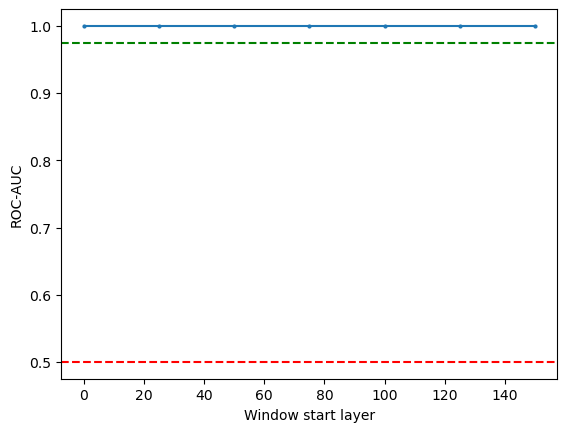

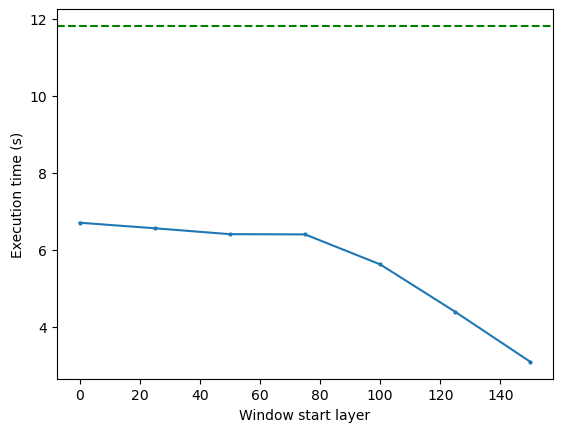

In [45]:
# Testing cell
from sklearn.metrics import f1_score, roc_auc_score
import time
twindowSize = windowSize
twindowAdvance = windowAdvance
# twindowSize = 50
# twindowAdvance = 25

oc1.reset()
ab = blockAccumulator(twindowSize, twindowAdvance)

# X_test = readCSet()
X_test = readRawHouseImages()
testObjects = np.moveaxis(X_test, 1, 0)
maskB = makeMaskB(X_test, emptyRatioB)
bgrb = backgroundRemover(maskB)

testx = []
predictions = []
letsPrint = False
times = []
labelRanges = [(i, i+twindowSize) for i in range(0, bend-twindowSize+1, twindowAdvance)]
# y_test = [getLabelsC(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,26)]
y_test = [getLabelsB(objIndex, 0.5, start, end) for (start, end) in labelRanges for objIndex in range(1,29)]
i = 0
for image in testObjects:
    # Start of timing
    i += 1
    start_time = time.time()
    noback = bgrb.removeBackground(image)
    # segments = makesegments(noback, hsegments)
    segments = noback
    segmentblocks = ab.next(segments)
    if(segmentblocks is False):
        continue
    ocvals = oc1.calculate(segmentblocks)
    hists = e1.encode(ocvals)
    pred = clf.predict_proba(hists)[:,1]
    times.append(time.time() - start_time)
    # End of timing
    testx.append(hists)
    predictions.append(pred)
# investigate accuracy etc here. Potentially batch it based on layer
ysvalue = []
for index, o in enumerate(predictions):
    ysvalue.append(roc_auc_score(y_test[index*28:(index+1)*28], o))
plt.plot([s for (s, e) in labelRanges], ysvalue, 'o-', markersize=2)
print(np.mean(ysvalue))
plt.ylabel("ROC-AUC")
plt.xlabel("Window start layer")
plt.axline((0, 0.975), (1, 0.975), color='g', linestyle='--')
plt.axline((0, 0.5), (1, 0.5), color='r', linestyle='--')
plt.figure()
plt.plot([s for (s, e) in labelRanges], times, 'o-', markersize=2)
plt.axline((0, 11.82), (1, 11.82), color='g', linestyle='--')
# plt.axline((0, 10.75), (1, 10.75), color='g', linestyle='--')
plt.ylabel("Execution time (s)")
plt.xlabel("Window start layer")

In [44]:
len(y_test)

189

In [43]:
ysvalue = []
for index, o in enumerate(predictions):
    ysvalue.append(roc_auc_score(y_test[index*28:(index+1)*28], o))
plt.plot([s for (s, e) in labelRanges], ysvalue, 'o-', markersize=2)
print(np.mean(ysvalue))
plt.ylabel("ROC-AUC")
plt.xlabel("Window start layer")
plt.axline((0, 0.975), (1, 0.975), color='g', linestyle='--')
plt.axline((0, 0.5), (1, 0.5), color='r', linestyle='--')
plt.figure()
plt.plot([s for (s, e) in labelRanges], times, 'o-', markersize=2)
plt.axline((0, 11.82), (1, 11.82), color='g', linestyle='--')
# plt.axline((0, 10.75), (1, 10.75), color='g', linestyle='--')
plt.ylabel("Execution time (s)")
plt.xlabel("Window start layer")

ValueError: Found input variables with inconsistent numbers of samples: [21, 28]

In [37]:
ytrain2

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [38]:

print(np.mean(ytrain2))
print(np.mean(ytrainb))
print(np.mean(y_test))
print(np.mean(predictions))

0.22857142857142856
0.24489795918367346
0.3028571428571429
0.0


In [39]:
# %run classes.ipynb
getCporosities(1, 0, 0, 1)

1.8907800274259903

In [40]:
# plt.hist(testx[0])
print(testx[0][0])
print(testx[0][24])

[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.39780130e-04
 9.38954629e-02 1.38671453e+00 1.97972805e-02 2.72203410e-04
 6.37593574e-05 1.22614149e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 2.45228298e-06
 2.77721047e-02 1.46558975e+00 7.51379504e-03 1.71659808e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [41]:
x[-1]

25